In [34]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICE"]="1"
import scipy
import csv
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import SimpleITK as sitk
import skimage.io as io
import pandas as pd
import time
%matplotlib inline

In [3]:
# 10 fold
num_train=math.ceil((154+93)/10 *9)
print( num_train)
num_test=math.floor((154+93)/10 *1)
print(num_test)
num_test_positive=math.floor(154/10)
num_test_negative=math.floor(93/10)
num_train_positive=154 - num_test_positive
num_train_negative=93 - num_test_negative
print(num_test_positive,num_test_negative,num_train_positive,num_train_negative)

223
24
15 9 139 84


In [10]:
#generate ten fold csv
counter_p=0
counter_n=0
i=0
# #image folder
image_folder='fengkai/lung_nodule/'
mask_folder='fengkai/nodule_mask'
def fold_csv(iter):
    return './fengkai/nodulefold/nodules_fold_{}.csv'.format(iter)
fold_iter=0

    
while(fold_iter<10):

    csv_fold=fold_csv(fold_iter)
    # create if not exists
    if not os.path.exists(csv_fold):
        open(csv_fold,'a').close()
    # first try
    if fold_iter==0:    
        image_list=sorted(os.listdir(image_folder))
    new_list=image_list
       
    with open (csv_fold, 'a') as csvfile:
        headers = ['image','mask']
        writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers) 
        writer.writeheader()
        
        for file in (image_list): 
            name=file.split('.')[0]

            if 'JPCLN' in name:
                # have lung nodule
                if counter_p<num_test_positive:

                    counter_p+=1
                    writer.writerow({'image':os.path.join(image_folder,file),
                                      'mask':os.path.join(mask_folder,name+'_mask.jpg')})
                    new_list.remove(file)
            else:
                # no nodule
                if counter_n <num_test_negative:
                    # put to train
                    counter_n+=1
                    writer.writerow({'image':os.path.join(image_folder,file),
                                      'mask':os.path.join(mask_folder,name+'_mask.jpg')})
                    new_list.remove(file)
            if counter_p==num_test_positive and counter_n == num_test_negative :
                counter_p=0
                counter_n=0
                fold_iter+=1
                image_list=new_list
                break

    

In [28]:


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Let's collect the real images to later on compare
# to the reconstructed ones
def to_binary(train_csv,tfrecords_filename):
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    original_images = []
    imageReader = csv.reader(open(train_csv), delimiter=',')
    #skin header
    next(imageReader)
    iter=0
    for row in imageReader:
    
        img_path,mask_path=row
#         print(img_path,mask_path)
        # add more except
        if 'image' == img_path or 'mask' == mask_path:
            continue
        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        height = img.shape[0]
        width = img.shape[1]
         # Put in the original images into array
        # Just for future check for correctness
        original_images.append((img, mask))
        img_raw = img.tostring()
        mask_raw = mask.tostring()

        example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(mask_raw)}))

        writer.write(example.SerializeToString())
        iter+=1
    writer.close()
    print('conversion done with{} '.format(iter))
    

In [30]:
# generate tfrecords
tfrecord_folder='./fengkai/lung_nodule_tenfold_tfrecords'
if not os.path.exists(tfrecord_folder):
    os.mkdir(tfrecord_folder)
fold_iter=0
train_csv='./fengkai/train_nodule_temp.csv'

if not os.path.exists(train_csv):
    open(train_csv,'a').close()
    
    
while(fold_iter<10):
    
    filenames=os.listdir('./fengkai/nodulefold/')
    print(filenames)
    if '.ipynb_checkpoints' in filenames:
        filenames.remove('.ipynb_checkpoints')
    # test binary file generate 1 partion
    tfrecords_filename = os.path.join(tfrecord_folder,'lung_nodule_testing_{}.tfrecords'.format(fold_iter))
    
    test_csv= './fengkai/nodulefold/nodules_fold_{}.csv'.format(fold_iter)
    to_binary(test_csv,tfrecords_filename)

    
    # 9 partion for train
    tfrecords_filename = os.path.join(tfrecord_folder,'lung_nodule_training_{}.tfrecords'.format(fold_iter))
    filenames.remove(test_csv.split('/')[-1])
    print(filenames)
    combined_csv = pd.concat( [ pd.read_csv(os.path.join('./fengkai/nodulefold/',f))  for f in filenames ] )
    combined_csv.to_csv( train_csv, index=False )
    to_binary(train_csv,tfrecords_filename)
    os.remove(train_csv)
    fold_iter+=1

['nodules_fold_9.csv', 'nodules_fold_2.csv', 'nodules_fold_0.csv', 'nodules_fold_3.csv', 'nodules_fold_7.csv', 'nodules_fold_1.csv', 'nodules_fold_8.csv', 'nodules_fold_6.csv', 'nodules_fold_4.csv', 'nodules_fold_5.csv']
conversion done with24 
['nodules_fold_9.csv', 'nodules_fold_2.csv', 'nodules_fold_3.csv', 'nodules_fold_7.csv', 'nodules_fold_1.csv', 'nodules_fold_8.csv', 'nodules_fold_6.csv', 'nodules_fold_4.csv', 'nodules_fold_5.csv']
conversion done with216 
['nodules_fold_9.csv', 'nodules_fold_2.csv', 'nodules_fold_0.csv', 'nodules_fold_3.csv', 'nodules_fold_7.csv', 'nodules_fold_1.csv', 'nodules_fold_8.csv', 'nodules_fold_6.csv', 'nodules_fold_4.csv', 'nodules_fold_5.csv']
conversion done with24 
['nodules_fold_9.csv', 'nodules_fold_2.csv', 'nodules_fold_0.csv', 'nodules_fold_3.csv', 'nodules_fold_7.csv', 'nodules_fold_8.csv', 'nodules_fold_6.csv', 'nodules_fold_4.csv', 'nodules_fold_5.csv']
conversion done with216 
['nodules_fold_9.csv', 'nodules_fold_2.csv', 'nodules_fold_0.c

In [31]:
#decode tfrecord
def read_and_decode(tfrecords_filename,if_aug,new_height,new_width,batch_size):
    # always queue the file name 

    filename_queue = tf.train.string_input_producer([tfrecords_filename])
    reader = tf.TFRecordReader()
    key, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)

    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = [height, width, 1]
    annotation_shape = [height, width, 1]
    #1D to 3D 
    image = tf.reshape(image,image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    # add fake color 
#     image=tf.image.grayscale_to_rgb(image)
    resized_image=tf.image.resize_images(image,[new_height,new_width],
                                                method=tf.image.ResizeMethod.BILINEAR)

    resized_annotation=tf.image.resize_images(annotation,[new_height,new_width],
                                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # if augment the image and maskr
    if if_aug:


        r_num=tf.random_uniform([1],minval=-0.01,maxval=0.01)

        resized_image=tf.contrib.image.rotate(resized_image,angles=r_num)
        resized_annotation=tf.contrib.image.rotate(resized_annotation,angles=r_num,interpolation='NEAREST')
        resized_image=tf.image.random_contrast(resized_image,lower=0.5,upper=0.9)
        resized_image=tf.image.random_brightness(resized_image,max_delta=0.1)
        
#         tf.set_random_seed(1234)
        
#         resized_image=tf.contrib.keras.preprocessing.image.random_zoom(x=resized_image,zoom_range=0.9,
#         row_axis=0,
#         col_axis=1,
#         channel_axis=2)
        
#         resized_annotation=tf.contrib.keras.preprocessing.image.random_zoom(x=resized_annotation,zoom_range=0.9,
#         row_axis=0,
#         col_axis=1,
#         channel_axis=2)
#     # random crop 
        
  

    ## no aug
    resized_image=tf.divide(resized_image,tf.reduce_max(resized_image))
    resized_annotation=tf.divide(resized_annotation,255)
    resized_annotation=tf.not_equal(resized_annotation,0)
    
       
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=batch_size,
                                                 capacity=300,
                                                 num_threads=2,
                                                 min_after_dequeue=20)

    return images, annotations
# # # visualize if the binary is ok

# tfrecords_filename = './fengkai/lung_nodule_testing.tfrecords'
# img_batch_op,mask_batch_op=read_and_decode(tfrecords_filename,if_aug=True,new_height=384,new_width=384,batch_size=2)


# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
# with session as sess:
#     # Start populating the filename queue.
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord)
#     sess.run(tf.global_variables_initializer())
    
#     for iter in range(0,200,2):
#         img_batch,mask_batch=sess.run([img_batch_op,mask_batch_op])
#         # plot to see the result match
#         print(np.max(img_batch[0,:,:,0]),np.median(mask_batch[0,:,:,0]))
#         plt.subplot(121)
#         plt.imshow(img_batch[0,:,:,0],cmap='gray')
#         plt.subplot(122)
# #         print(mask_batch.shape)
#         plt.imshow(mask_batch[0,:,:,0],cmap='gray')
#         plt.show()


#     print('csv_read ok')
#     coord.request_stop()
#     coord.join(threads) 

In [32]:
# layer U-net
def conv_conv_pool(input_, n_filters, training, name, pool=True, activation=tf.nn.relu):
    """{Conv -> BN -> RELU}x2 -> {Pool, optional}
    Args:
        input_ (4-D Tensor): (batch_size, H, W, C)
        n_filters (list): number of filters [int, int]
        training (1-D Tensor): Boolean Tensor
        name (str): name postfix
        pool (bool): If True, MaxPool2D
        activation: Activaion functions
    Returns:
        net: output of the Convolution operations
        pool (optional): output of the max pooling operations
    """
    net = input_

    with tf.variable_scope("layer{}".format(name)):
        for i, F in enumerate(n_filters):
            net = tf.layers.conv2d(net, F, (3, 3), activation=None, padding='same', name="conv_{}".format(i + 1))
            tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")(net)
            net = tf.layers.batch_normalization(net, training=training, name="bn_{}".format(i + 1))
             # remove bn
            net = activation(net, name="relu{}_{}".format(name, i + 1))
            

        if pool is False:
            return net

        pool = tf.layers.max_pooling2d(net, (2, 2), strides=(2, 2), name="pool_{}".format(name))

        return net, pool


def upsample_concat(inputA, input_B, name):
    """Upsample `inputA` and concat with `input_B`
    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation
    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    upsample = upsampling_2D(inputA, size=(2, 2), name=name)

    return tf.concat([upsample, input_B], axis=-1, name="concat_{}".format(name))


def upsampling_2D(tensor, name, size=(2, 2)):
    """Upsample/Rescale `tensor` by size
    Args:
        tensor (4-D Tensor): (N, H, W, C)
        name (str): name of upsampling operations
        size (tuple, optional): (height_multiplier, width_multiplier)
            (default: (2, 2))
    Returns:
        output (4-D Tensor): (N, h_multiplier * H, w_multiplier * W, C)
    """
    H, W, _ = tensor.get_shape().as_list()[1:]

    H_multi, W_multi = size
    target_H = H * H_multi
    target_W = W * W_multi

    return tf.image.resize_nearest_neighbor(tensor, (target_H, target_W), name="upsample_{}".format(name))


def make_unet(X, training):
    """Build a U-Net architecture
    Args:
        X (4-D Tensor): (N, H, W, C)
        training (1-D Tensor): Boolean Tensor is required for batchnormalization layers
    Returns:
        output (4-D Tensor): (N, H, W, C)
            Same shape as the `input` tensor
    Notes:
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    """
    
    net = tf.layers.conv2d(X, 3, (1, 1), name="color_space_adjust")
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, name=1)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, name=2)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, name=3)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, name=4)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    conv5 = conv_conv_pool(pool4, [128, 128], training, name=5, pool=False)
#     tf.keras.layers.SpatialDropout2D(rate=0.5,data_format="channels_last")
    up6 = upsample_concat(conv5, conv4, name=6)
    conv6 = conv_conv_pool(up6, [64, 64], training, name=6, pool=False)

    up7 = upsample_concat(conv6, conv3, name=7)
    conv7 = conv_conv_pool(up7, [32, 32], training, name=7, pool=False)

    up8 = upsample_concat(conv7, conv2, name=8)
    conv8 = conv_conv_pool(up8, [16, 16], training, name=8, pool=False)

    up9 = upsample_concat(conv8, conv1, name=9)
    conv9 = conv_conv_pool(up9, [8, 8], training, name=9, pool=False)
    conv10=tf.layers.conv2d(conv9, 1, (1, 1), name='final', activation=tf.nn.sigmoid, padding='same')
    
    return conv10



In [33]:
# loss define and train op
def IOU_(y_pred, y_true):
    """Returns a (approx) IOU score
    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7
    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)
    Returns:
        float: IOU score
    """
    
    
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    #to 0-1
    pred_flat=pred_flat/(tf.reduce_max(pred_flat)+ 1e-7)
    true_flat=true_flat/(tf.reduce_max(true_flat)+ 1e-7)

    intersection =  2*tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)


def make_train_op(y_pred, y_true):
    """Returns a training operation
    Loss function = - IOU(y_pred, y_true)
    IOU is
        (the area of intersection)
        --------------------------
        (the area of two boxes)
    Args:
        y_pred (4-D Tensor): (N, H, W, 1)
        y_true (4-D Tensor): (N, H, W, 1)
    Returns:
        train_op: minimize operation
    """
    loss =-IOU_(y_pred, y_true)

    global_step = tf.train.get_or_create_global_step()

    optim = tf.train.AdamOptimizer()
    return optim.minimize(loss, global_step=global_step)


In [ ]:
fold_iter=-1
while(fold_iter<10):
    fold_iter+=1
    logdir='./fengkai/Unet_nodule'
    ckdir ='./fengkai/Unet_nodule_model_fold_{}'.format(fold_iter)
    if not os.path.exists(logdir):
        os.mkdir(logdir)

    current_time = time.strftime("%m/%d/%H/%M/%S")
    train_logdir = os.path.join(logdir, "train", current_time)
    test_logdir = os.path.join(logdir, "test", current_time)
    # parameter setting
    n_train=223
    n_test=24
    new_height=512
    new_width=new_height
    epochs=800
    batch_size=4
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="X")
    y = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="y")
    mode = tf.placeholder(tf.bool, name="mode")

    pred = make_unet(X, mode)
    # pred=tf.cast(tf.not_equal(pred,0),dtype=tf.float32)
    tf.add_to_collection("inputs", X)
    tf.add_to_collection("inputs", mode)
    tf.add_to_collection("outputs", pred)

    tf.summary.histogram("Predicted_Mask", pred)
    tf.summary.image("Predicted_Mask", pred)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        train_op = make_train_op(pred, y)

    IOU_op = IOU_(pred, y)
    IOU_op = tf.Print(IOU_op, [IOU_op])
    tf.summary.scalar("IOU", IOU_op)





    #train image mask batch op
    #train image mask batch op
    train_tfrecords_filename = './fengkai/lung_nodule_tenfold_tfrecords/lung_nodule_training_{}.tfrecords'.format(fold_iter)
    train_img_batch_op,train_mask_batch_op=read_and_decode(train_tfrecords_filename,if_aug=True,new_height=new_height,new_width=new_width,batch_size=batch_size)
    #test image mask batch op
    test_tfrecords_filename = './fengkai/lung_nodule_tenfold_tfrecords/lung_nodule_testing_{}.tfrecords'.format(fold_iter)
    test_img_batch_op,test_mask_batch_op=read_and_decode(test_tfrecords_filename,if_aug=False,new_height=new_height,new_width=new_width,batch_size=batch_size)


    summary_op = tf.summary.merge_all()


    config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4))

    # config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    with session as sess:
        # Start populating the filename queue.
        train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
        test_summary_writer = tf.summary.FileWriter(test_logdir)

    #     coord = tf.train.Coordinator()
    #     threads = tf.train.start_queue_runners(coord=coord)
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if os.path.exists(ckdir) and tf.train.checkpoint_exists(ckdir):
            latest_check_point = tf.train.latest_checkpoint(ckdir)
            saver.restore(sess, latest_check_point)

        else:
            try:
                os.rmdir(ckdir)
            except FileNotFoundError:
                pass
            os.mkdir(ckdir)


        try:
            global_step = tf.train.get_global_step(sess.graph)

            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)
            counter_till_break=0
            for epoch in range(epochs):
                train_iou=0
                for step in range(0, n_train, batch_size):

                    X_batch, y_batch = sess.run([train_img_batch_op,train_mask_batch_op])

                    _, step_iou, step_summary, global_step_value = sess.run(
                        [train_op, IOU_op, summary_op, global_step],
                        feed_dict={X: X_batch,
                                   y: y_batch,
                                   mode: True})
                    train_iou += step_iou * X_batch.shape[0]

                    train_summary_writer.add_summary(step_summary, global_step_value)

                total_iou = 0
                for step in range(0, n_test, batch_size):
                    X_test, y_test = sess.run([test_img_batch_op,test_mask_batch_op])
                    step_iou, step_summary = sess.run(
                        [IOU_op, summary_op],
                        feed_dict={X: X_test,
                                   y: y_test,
                                   mode: False})

                    total_iou += step_iou * X_test.shape[0]

                    test_summary_writer.add_summary(step_summary, (epoch + 1) * (step + 1))


                print("fold : {},epoch :{},IOU for training is {} for test  is {} ".format(fold_iter,epoch,train_iou/n_train,
                                                                                 total_iou/n_test))

                if total_iou/n_test > 0.15 and total_iou/n_test< 0.16:
                    print('saving the checkpoint')
                    counter_till_break+=1
                    saver.save(sess, "{}/model{}.ckpt".format(ckdir,epoch))
                if counter_till_break > 5:
                    

                    
                    
                    break

        finally:
            coord.request_stop()
            coord.join(threads)
    #         saver.save(sess, "{}/model{}.ckpt".format(ckdir,epoch))


fold : 0,epoch :0,IOU for training is 0.0044930236384964255 for test  is 0.005946732494824876 
fold : 0,epoch :1,IOU for training is 0.005455313778755577 for test  is 0.006602766457945108 
fold : 0,epoch :2,IOU for training is 0.00533358220611709 for test  is 0.007530248452288409 
fold : 0,epoch :3,IOU for training is 0.0055427708299866565 for test  is 0.009272889389346043 
fold : 0,epoch :4,IOU for training is 0.005793106427950822 for test  is 0.015196720914294323 
fold : 0,epoch :5,IOU for training is 0.00626649910946929 for test  is 0.005632781889428823 
fold : 0,epoch :6,IOU for training is 0.006445235813975774 for test  is 0.013096893516679605 
fold : 0,epoch :7,IOU for training is 0.007297257035617669 for test  is 0.015865580605653424 
fold : 0,epoch :8,IOU for training is 0.007782329803107164 for test  is 0.011957224613676468 
fold : 0,epoch :9,IOU for training is 0.008755909493576382 for test  is 0.004330809907528731 
fold : 0,epoch :10,IOU for training is 0.008702327009745799 

fold : 0,epoch :88,IOU for training is 0.23327976481848492 for test  is 0.30672258883714676 
fold : 0,epoch :89,IOU for training is 0.2524601050120745 for test  is 0.0012068071213964988 
fold : 0,epoch :90,IOU for training is 0.18869162578337195 for test  is 0.07865365862865777 
fold : 0,epoch :91,IOU for training is 0.261451671043013 for test  is 0.1877861280615131 
fold : 0,epoch :92,IOU for training is 0.2530458506717281 for test  is 0.22000395736540668 
fold : 0,epoch :93,IOU for training is 0.2217812305809958 for test  is 0.3260004272063573 
fold : 0,epoch :94,IOU for training is 0.2363223541558337 for test  is 0.2509307414293289 
fold : 0,epoch :95,IOU for training is 0.2318210412847637 for test  is 0.21879962335030237 
fold : 0,epoch :96,IOU for training is 0.23860974196032766 for test  is 0.168195932006635 
fold : 0,epoch :97,IOU for training is 0.25679837958492097 for test  is 0.129977787566285 
fold : 0,epoch :98,IOU for training is 0.28540949097306006 for test  is 0.33874424

fold : 0,epoch :176,IOU for training is 0.3231248947997695 for test  is 0.063924779821899 
fold : 0,epoch :177,IOU for training is 0.3190983841367478 for test  is 0.13477906907276824 
fold : 0,epoch :178,IOU for training is 0.3128905226366463 for test  is 0.18460646415284523 
fold : 0,epoch :179,IOU for training is 0.33638398644642525 for test  is 0.2527204815382902 
fold : 0,epoch :180,IOU for training is 0.3112292359610463 for test  is 0.15152015599111715 
saving the checkpoint
fold : 0,epoch :181,IOU for training is 0.3613027567442394 for test  is 0.38941432163119316 
fold : 0,epoch :182,IOU for training is 0.3258407805567747 for test  is 0.19195565360248557 
fold : 0,epoch :183,IOU for training is 0.34675113020769516 for test  is 0.21124023447434107 
fold : 0,epoch :184,IOU for training is 0.32250553037226937 for test  is 0.3031453664104144 
fold : 0,epoch :185,IOU for training is 0.2915713515446167 for test  is 0.025130138759171434 
fold : 0,epoch :186,IOU for training is 0.318114

fold : 0,epoch :264,IOU for training is 0.3542767527967915 for test  is 0.24270239019324436 
fold : 0,epoch :265,IOU for training is 0.35300294841004115 for test  is 0.27435916662216187 
fold : 0,epoch :266,IOU for training is 0.377174370525324 for test  is 0.1700527230650989 
fold : 0,epoch :267,IOU for training is 0.38910248732289504 for test  is 0.28434451278007405 
fold : 0,epoch :268,IOU for training is 0.37542500676767293 for test  is 0.2725969087332487 
fold : 0,epoch :269,IOU for training is 0.36751080966142097 for test  is 0.32521797592441243 
fold : 0,epoch :270,IOU for training is 0.3993489743763722 for test  is 0.21297148366769156 
fold : 0,epoch :271,IOU for training is 0.4030959977607004 for test  is 0.19860204568719078 
fold : 0,epoch :272,IOU for training is 0.3368135871279819 for test  is 0.07464269516214728 
fold : 0,epoch :273,IOU for training is 0.4300645608424436 for test  is 0.041124813932109795 
fold : 0,epoch :274,IOU for training is 0.3703032907677012 for test 

fold : 0,epoch :353,IOU for training is 0.40377022898013365 for test  is 0.38016875088214874 
fold : 0,epoch :354,IOU for training is 0.4009189171568572 for test  is 0.26295864830414456 
fold : 0,epoch :355,IOU for training is 0.416280390951582 for test  is 0.20798183662918746 
fold : 0,epoch :356,IOU for training is 0.38379749633891436 for test  is 0.37606889257828396 
fold : 0,epoch :357,IOU for training is 0.41426156967436695 for test  is 0.18114182863306874 
fold : 0,epoch :358,IOU for training is 0.41323242437784957 for test  is 0.20464925734389303 
fold : 0,epoch :359,IOU for training is 0.44243355458253647 for test  is 0.13165630828901462 
fold : 0,epoch :360,IOU for training is 0.43514730352862113 for test  is 0.11280953762512493 
fold : 0,epoch :361,IOU for training is 0.10574141439413087 for test  is 0.07397812420445322 
fold : 0,epoch :362,IOU for training is 0.21550151848548432 for test  is 5.4507361840240576e-11 
fold : 0,epoch :363,IOU for training is 0.004494620902985039

fold : 1,epoch :70,IOU for training is 0.11562996380998322 for test  is 0.12478086636616581 
fold : 1,epoch :71,IOU for training is 0.15001575214289145 for test  is 0.12335835468754652 
fold : 1,epoch :72,IOU for training is 0.11214303147896552 for test  is 0.0992536581053211 
fold : 1,epoch :73,IOU for training is 0.1354280448218856 for test  is 0.1720727828177928 
fold : 1,epoch :74,IOU for training is 0.11183021207396625 for test  is 0.1715674807007114 
fold : 1,epoch :75,IOU for training is 0.10545951365665292 for test  is 0.23468234778071442 
fold : 1,epoch :76,IOU for training is 0.13759226161832863 for test  is 0.1149776724179598 
fold : 1,epoch :77,IOU for training is 0.12060073096171642 for test  is 0.14576762317922962 
fold : 1,epoch :78,IOU for training is 0.14131202539130455 for test  is 0.22782535975178084 
fold : 1,epoch :79,IOU for training is 0.11076324078965219 for test  is 0.10353306863448115 
fold : 1,epoch :80,IOU for training is 0.14674455249581145 for test  is 0.1

fold : 1,epoch :158,IOU for training is 0.3149250843269777 for test  is 0.23107540110747019 
fold : 1,epoch :159,IOU for training is 0.2591999146893969 for test  is 0.23316484589973166 
fold : 1,epoch :160,IOU for training is 0.35184767286570606 for test  is 0.28751049811641377 
fold : 1,epoch :161,IOU for training is 0.2829957117498979 for test  is 0.1821095459163189 
fold : 1,epoch :162,IOU for training is 0.28926217685968536 for test  is 0.1684105331403316 
fold : 1,epoch :163,IOU for training is 0.3095014476430578 for test  is 0.2073307925710489 
fold : 1,epoch :164,IOU for training is 0.2935945898164506 for test  is 0.26943155626455945 
fold : 1,epoch :165,IOU for training is 0.28694811671754017 for test  is 0.08418059286459822 
fold : 1,epoch :166,IOU for training is 0.29949908354785876 for test  is 0.1891201085721453 
fold : 1,epoch :167,IOU for training is 0.321117764546625 for test  is 0.05510074614736974 
fold : 1,epoch :168,IOU for training is 0.35214297886506546 for test  i

In [30]:
# for visualization
fold_iter=-1
while(fold_iter<10):
    fold_iter+=1
    logdir='./fengkai/Unet_nodule'
    ckdir ='./fengkai/Unet_nodule_model_fold_{}'.format(fold_iter)
    if not os.path.exists(logdir):
        os.mkdir(logdir)

    current_time = time.strftime("%m/%d/%H/%M/%S")
    train_logdir = os.path.join(logdir, "train", current_time)
    test_logdir = os.path.join(logdir, "test", current_time)
    # parameter setting
    n_train=223
    n_test=24
    new_height=512
    new_width=new_height
    epochs=1
    batch_size=1
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="X")
    y = tf.placeholder(tf.float32, shape=[None, new_width, new_height, 1], name="y")
    mode = tf.placeholder(tf.bool, name="mode")

    pred = make_unet(X, mode)
    # pred=tf.cast(tf.not_equal(pred,0),dtype=tf.float32)
    tf.add_to_collection("inputs", X)
    tf.add_to_collection("inputs", mode)
    tf.add_to_collection("outputs", pred)

    tf.summary.histogram("Predicted_Mask", pred)
    tf.summary.image("Predicted_Mask", pred)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        train_op = make_train_op(pred, y)

    IOU_op = IOU_(pred, y)
    IOU_op = tf.Print(IOU_op, [IOU_op])
    tf.summary.scalar("IOU", IOU_op)





    #train image mask batch op
    #train image mask batch op
    train_tfrecords_filename = './fengkai/lung_nodule_tenfold_tfrecords/lung_nodule_training_{}.tfrecords'.format(fold_iter)
    train_img_batch_op,train_mask_batch_op=read_and_decode(train_tfrecords_filename,if_aug=True,new_height=new_height,new_width=new_width,batch_size=batch_size)
    #test image mask batch op
    test_tfrecords_filename = './fengkai/lung_nodule_tenfold_tfrecords/lung_nodule_testing_{}.tfrecords'.format(fold_iter)
    test_img_batch_op,test_mask_batch_op=read_and_decode(test_tfrecords_filename,if_aug=False,new_height=new_height,new_width=new_width,batch_size=batch_size)


    summary_op = tf.summary.merge_all()


    config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4))

    # config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    with session as sess:
        # Start populating the filename queue.
        train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
        test_summary_writer = tf.summary.FileWriter(test_logdir)

    #     coord = tf.train.Coordinator()
    #     threads = tf.train.start_queue_runners(coord=coord)
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if os.path.exists(ckdir) and tf.train.checkpoint_exists(ckdir):
            latest_check_point = tf.train.latest_checkpoint(ckdir)
            saver.restore(sess, latest_check_point)
            try:
                global_step = tf.train.get_global_step(sess.graph)

                coord = tf.train.Coordinator()
                threads = tf.train.start_queue_runners(coord=coord)

                for epoch in range(epochs):

                    for step in range(0, n_test, batch_size):
                        X_test, y_test = sess.run([test_img_batch_op,test_mask_batch_op])
                        image,label,predict = sess.run(
                            [X,y,pred],
                            feed_dict={X: X_test,
                                       y: y_test,
                                       mode: False})

                        image_2d=image[0,:,:,0]*255
                        label_2d=label[0,:,:,0]*255
                        predict_2d=predict[0,:,:,0]/np.max(predict[0,:,:,0])*255

                        cv2.imwrite('./fengkai/U-net-prediction-images_fold_{}/image/{}.png'.format(fold_iter,step),image_2d)
                        cv2.imwrite('./fengkai/U-net-prediction-images_fold_{}/label/{}.png'.format(fold_iter, step),label_2d)
                        cv2.imwrite('./fengkai/U-net-prediction-images_fold_{}/predict/{}.png'.format(fold_iter, step),predict_2d)
            finally:
                coord.request_stop()
                coord.join(threads)

INFO:tensorflow:Restoring parameters from ./fengkai/Unet_nodule_model/model152.ckpt


INFO:tensorflow:Restoring parameters from ./fengkai/Unet_nodule_model/model152.ckpt


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer, input_producer/RandomShuffle)]]


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer, input_producer/RandomShuffle)]]


In [6]:
# tp=1+1+1+1+1+1+1+1+1+1
# fn=1+1
# fp=5+1+4+2+1+1+1+1
# recall=tp/(tp+fn)
# precision=tp/(tp+fp)
# print('After U-net manual')
# print('recall={}'.format(recall))
# print('precision={}'.format(precision))

After U-net manual
recall=0.8333333333333334
precision=0.38461538461538464


In [28]:
def getROICenters(itk_image, radius):
    itk_image = sitk.BinaryMorphologicalClosing(itk_image, radius)
    itk_image = sitk.ConnectedComponent(itk_image,fullyConnected=False)
    label_shape_analysis = sitk.LabelShapeStatisticsImageFilter()
    nodules = []
    label_shape_analysis.Execute(itk_image)
    num_labels = label_shape_analysis.GetNumberOfLabels()
    backg=0
    label_shape_analysis.SetBackgroundValue(backg)
#    print(num_labels,backg)
    for l_i in range(1, num_labels + 1):
        center = label_shape_analysis.GetCentroid(l_i)
        nodules.append(center)
        print("Center:", center)
    print("found n nodules", len(nodules))
    return nodules

24
/home/fengkai/fengkai/U-net-prediction-images/predict/0.png
Center: (240.0, 168.5)
found n nodules 1


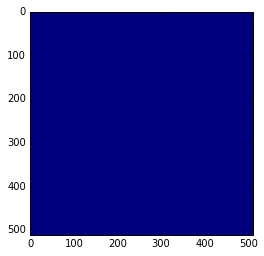

/home/fengkai/fengkai/U-net-prediction-images/predict/1.png
Center: (510.0, 194.5)
found n nodules 1


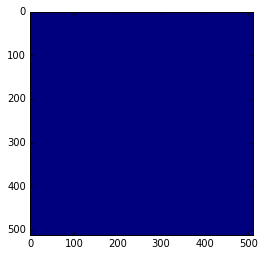

/home/fengkai/fengkai/U-net-prediction-images/predict/2.png
Center: (97.0, 178.0)
found n nodules 1


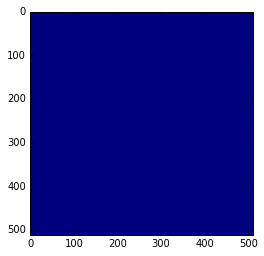

/home/fengkai/fengkai/U-net-prediction-images/predict/3.png
Center: (426.13475177304963, 251.9952718676123)
found n nodules 1


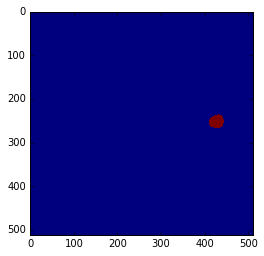

/home/fengkai/fengkai/U-net-prediction-images/predict/4.png
Center: (258.0, 123.0)
found n nodules 1


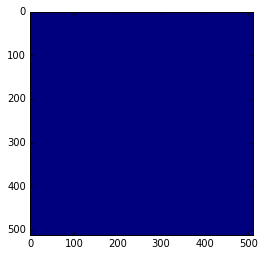

/home/fengkai/fengkai/U-net-prediction-images/predict/5.png
Center: (385.4413646055437, 245.19402985074626)
found n nodules 1


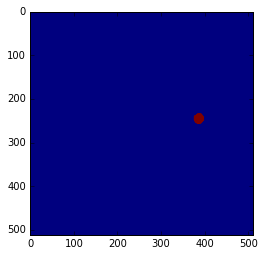

/home/fengkai/fengkai/U-net-prediction-images/predict/6.png
Center: (149.62529832935562, 179.1527446300716)
found n nodules 1


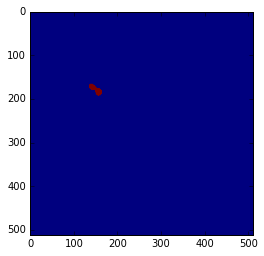

/home/fengkai/fengkai/U-net-prediction-images/predict/7.png
Center: (138.69157392686805, 288.5612082670906)
found n nodules 1


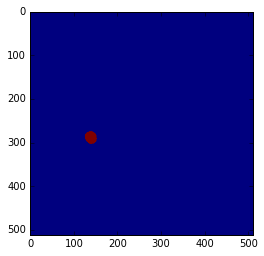

/home/fengkai/fengkai/U-net-prediction-images/predict/8.png
Center: (138.69157392686805, 288.5612082670906)
found n nodules 1


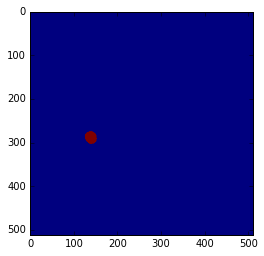

/home/fengkai/fengkai/U-net-prediction-images/predict/9.png
Center: (146.43342036553526, 326.5744125326371)
found n nodules 1


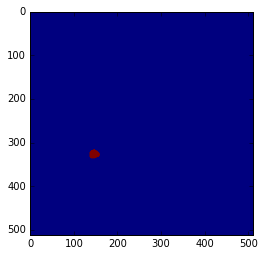

/home/fengkai/fengkai/U-net-prediction-images/predict/10.png
Center: (510.0, 194.5)
found n nodules 1


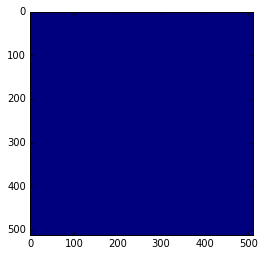

/home/fengkai/fengkai/U-net-prediction-images/predict/11.png
Center: (396.8553459119497, 218.125786163522)
found n nodules 1


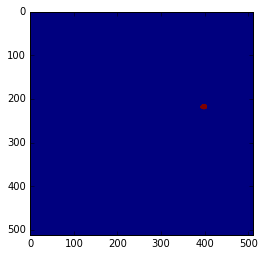

/home/fengkai/fengkai/U-net-prediction-images/predict/12.png
Center: (197.33333333333334, 201.25)
found n nodules 1


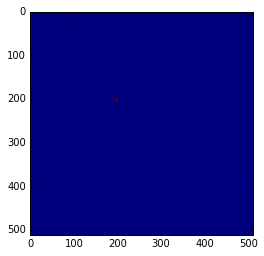

/home/fengkai/fengkai/U-net-prediction-images/predict/13.png
Center: (398.7027027027027, 134.78378378378378)
found n nodules 1


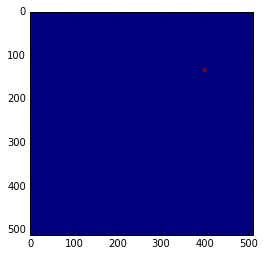

/home/fengkai/fengkai/U-net-prediction-images/predict/14.png
Center: (321.0, 95.0)
found n nodules 1


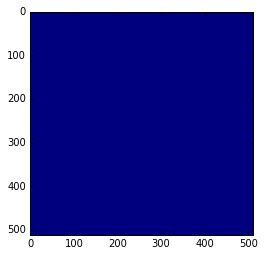

/home/fengkai/fengkai/U-net-prediction-images/predict/15.png
Center: (146.43342036553526, 326.5744125326371)
found n nodules 1


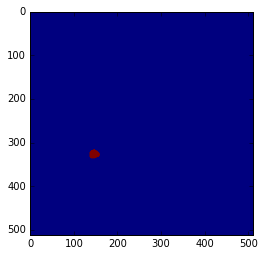

/home/fengkai/fengkai/U-net-prediction-images/predict/16.png
Center: (444.0601503759398, 281.65664160401)
Center: (101.45333333333333, 397.73333333333335)
found n nodules 2


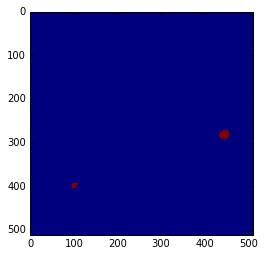

/home/fengkai/fengkai/U-net-prediction-images/predict/17.png
Center: (122.49753694581281, 314.4039408866995)
found n nodules 1


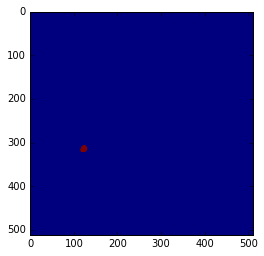

/home/fengkai/fengkai/U-net-prediction-images/predict/18.png
Center: (152.482, 121.694)
Center: (439.48660714285717, 286.36607142857144)
Center: (66.49668874172185, 303.7041942604857)
Center: (436.69417475728153, 354.61893203883494)
found n nodules 4


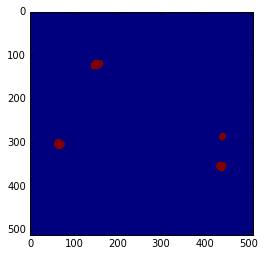

/home/fengkai/fengkai/U-net-prediction-images/predict/19.png
Center: (97.0, 178.0)
found n nodules 1


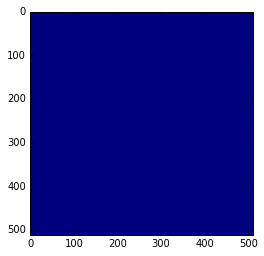

/home/fengkai/fengkai/U-net-prediction-images/predict/20.png
Center: (510.0, 194.5)
found n nodules 1


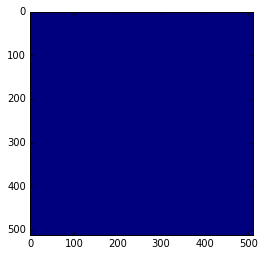

/home/fengkai/fengkai/U-net-prediction-images/predict/21.png
Center: (345.5, 90.5)
found n nodules 1


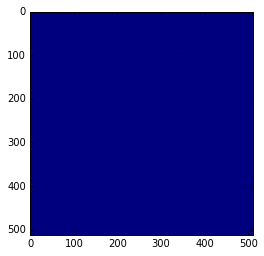

/home/fengkai/fengkai/U-net-prediction-images/predict/22.png
Center: (149.62529832935562, 179.1527446300716)
found n nodules 1


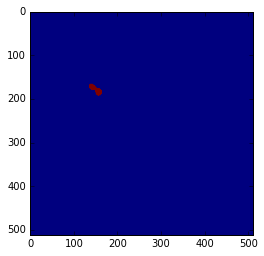

/home/fengkai/fengkai/U-net-prediction-images/predict/23.png
Center: (398.7027027027027, 134.78378378378378)
found n nodules 1


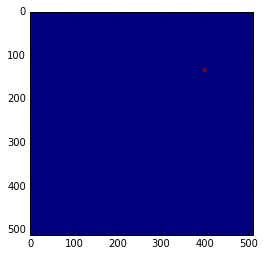

In [39]:
# vector index selection 
# make coordinate file for testresults 
import pylab
from pylab import imshow
import csv 
fold_iter=-1
threshold=50
flag=False
def euclidean_distance(Groud_truth,predict):
    return math.sqrt((Groud_truth[0]-predict[0])**2+(Groud_truth[1]-predict[1])**2)
while(fold_iter<10):
    fold_iter+=1

    tp=0
    fn=0
    fp=0

    testResultPath = '/home/fengkai/fengkai/U-net-prediction-images_fold_{}/predict/'.format(fold_iter)
    testGroundtruthPath='/home/fengkai/fengkai/U-net-prediction-images_fold_{}/label/'.format(fold_iter)


    testResult= os.listdir(testResultPath)


    totalnumberofTest = len(testResult)-1
    print(totalnumberofTest)
    split=0.99
    coordinateofTest=np.zeros((10000,3))
    coordinateoflabel=np.zeros((10000,3))    
    count =0

    allcountbefore=0
    for count in range(totalnumberofTest):

        fname = testResultPath+'{}.png'.format(count)
        print(fname)
        itk_image = sitk.ReadImage(fname)
        itk_image_after_cast = sitk.Cast(itk_image, sitk.sitkUInt64)
        slice_sitk = sitk.GetArrayFromImage(itk_image_after_cast)

        up = np.divide(np.max(slice_sitk),1.00000)

        slice_sitk =sitk.BinaryThreshold(itk_image_after_cast,split*up,up,1,0)
        numpy_slice_sitk=sitk.GetArrayFromImage(slice_sitk)
        imshow(numpy_slice_sitk)
        nodules=getROICenters(slice_sitk,10)
        pylab.show()
        labels =len(nodules)
        la=0
        for nodule in nodules:
            coordinateofTest[allcountbefore+la,0]=count # number of file
            coordinateofTest[allcountbefore+la,1]=nodules[la][0]#x 
            coordinateofTest[allcountbefore+la,2]=nodules[la][1]#y
            la = la+1

        allcountbefore = allcountbefore+labels
    
    with open('./fengkai/coordinatepredict_{}.txt'.format(fold_iter), 'a') as f:

        for n,x, y in coordinateofTest: 
            f.write('{} {} {}\n'.format(n,x, y))

    ## for ground truth        
    count =0
    allcountbefore=0        
    for count in range(totalnumberofTest):

        fname = testGroundtruthPath+'{}.png'.format(count)
        print(fname)
        itk_image = sitk.ReadImage(fname)
        itk_image_after_cast = sitk.Cast(itk_image, sitk.sitkUInt64)
        slice_sitk = sitk.GetArrayFromImage(itk_image_after_cast)

        up = np.divide(np.max(slice_sitk),1.00000)

        slice_sitk =sitk.BinaryThreshold(itk_image_after_cast,split*up,up,1,0)
        numpy_slice_sitk=sitk.GetArrayFromImage(slice_sitk)
        imshow(numpy_slice_sitk)
        nodules=getROICenters(slice_sitk,10)
        pylab.show()
        labels =len(nodules)
        la=0
        for nodule in nodules:
            coordinateoflabel[allcountbefore+la,0]=count # number of file
            coordinateoflabel[allcountbefore+la,1]=nodules[la][0]#x 
            coordinateoflabel[allcountbefore+la,2]=nodules[la][1]#y
            la = la+1

        allcountbefore = allcountbefore+labels
    

    with open('./fengkai/coordinatelabel_{}.txt'.format(fold_iter), 'a') as f:

        for n,x, y in coordinateoflabel: 
            f.write('{} {} {}\n'.format(n,x, y))     
            
    # calculate here
    for n,x, y in coordinateoflabel: 
        # find all the rows with n 
        for p_n, p_x,p_y in coordinateofTest:
            if p_n ==n :
                ground_truth=[x,y]
                predict_test=[p_x,p_y]
                if euclidean_distance(ground_truth,predict_test)< threshold:
                    # truth positive
                    tp +=1 
                    flag=True
                else :
                    fp +=1
        if not flag : 
            fn+=1 

    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    print('After U-net fold {}'.format(fold_iter))
    print('recall={}'.format(recall))
    print('precision={}'.format(precision))
    
    
